# Basic Backtester

- You are initially given a df of data
- At each timestep,
    you must give your signals to buy/sell
    then we finish the day, and give you the day's new row of data

In [9]:
""" 
Imports
"""

import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
from itertools import combinations
from tqdm import tqdm
import typing
from typing import Dict, Union
import collections

In [10]:
class Backtester:
    def __init__(self, start_train, end_train, end_test, increment):
        self.start_train = start_train
        self.end_train = end_train
        self.end_test = end_test
        self.increment = increment

        self.df = pd.read_csv('./crypto_data.csv')
        self.df['time'] = pd.to_datetime(self.df['time'])
        self.df = self.df.set_index('time')

        self.df  = self.df.dropna(how='all', axis=0)
        self.df  = self.df.dropna(how='all', axis=1)

        self.tickers = list(set([col.split('_')[0] for col in self.df.columns]))

        self.currDate = start_train
        self.dates = [start_train]
        self.pnls = [0]
        self.fees = [0]
        self.positions = [collections.defaultdict(float)]
    
    def get_tickers(self):
        return self.tickers
    
    def get_day_data(self):
        return self.df.loc[self.currDate]

    def get_all_data(self):
        return self.df.loc[self.start_train:self.currDate]
    
    def get_position(self):
        return self.positions[-1]
    
    def get_pnl(self):
        return self.pnls[-1]
    
    def get_date(self):
        return self.currDate
    
    def get_all_positions(self):
        return self.positions
    
    def get_all_pnls(self):
        return self.pnls
    
    def get_all_dates(self):
        return self.dates
    
    def pass_day(self, pnlChange=0):
        yesterdayData = self.get_day_data()
        self.currDate = self.currDate + self.increment
        self.dates.append(self.currDate)
        todayData = self.get_day_data()
        
        for ticker, amount in self.positions[-1].items():
            priceChange = todayData[f"{ticker}_close"] - yesterdayData[f"{ticker}_close"]
            pnlChange += amount * priceChange
        self.pnls.append(self.pnls[-1] + pnlChange)

    def input_signals(self, signals: typing.Dict[str, Union[int, float]], includeFees = True, minSize=True):
        # 1. Updates positions
        tickerSet = set(self.tickers)
        prevPositions: collections.defaultdict = self.positions[-1].copy()
        feesPaid = 0

        for ticker, amount in signals.items():
            if ticker not in tickerSet: raise ValueError("Ticker not valid")

            tickerPrice = self.get_day_data()[f"{ticker}_close"]
            transactionPrice = amount * tickerPrice
            if minSize and abs(transactionPrice) < 5: continue

            prevPositions[ticker] += amount

            # Fees
            if includeFees:
                feeMultiplier = 0.055/100
                feesPaid += tickerPrice * feeMultiplier * abs(amount)

        self.positions.append(prevPositions)
        self.fees.append(self.fees[-1] + feesPaid)

        # 2. Calls pass day to do any other calculations
        self.pass_day(-feesPaid)
    
    def graph_pnl(self, title = 'Pnl over Time'):
        x = self.get_all_dates()
        y = self.get_all_pnls()

        tick_locs = x[::len(x)//4]
        plt.plot(x, y)
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Pnl')
        plt.xticks(tick_locs, tick_locs, rotation=45)
        plt.axvline(x=self.end_train, color='red', linestyle='--')
        plt.show()

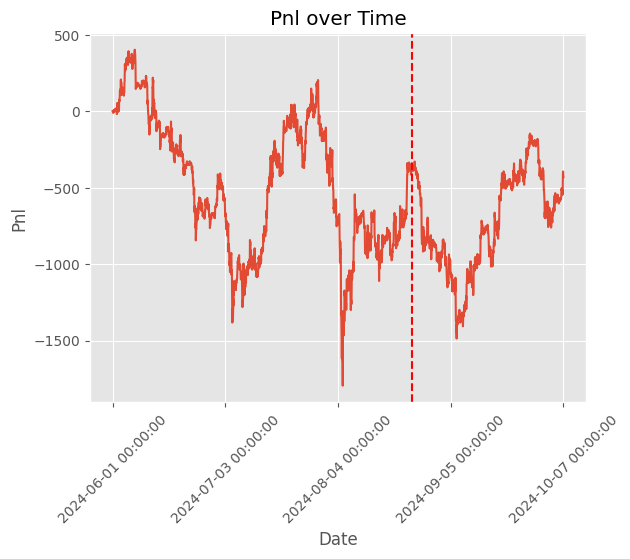

''

In [11]:
"""
Sample: buying 1 bitcoing and holding
"""
start_time = datetime(2024, 6, 1, 0, 0)
end_time = datetime(2024, 8, 25, 0, 0)
test_end_time = datetime(2024, 10, 7, 0, 0)
increment = timedelta(hours=1)

b = Backtester(start_time, end_time, test_end_time, increment)
b.input_signals({'BTCUSDT': 0.1})

while b.get_date() < test_end_time:
    b.input_signals({})
b.graph_pnl()
;

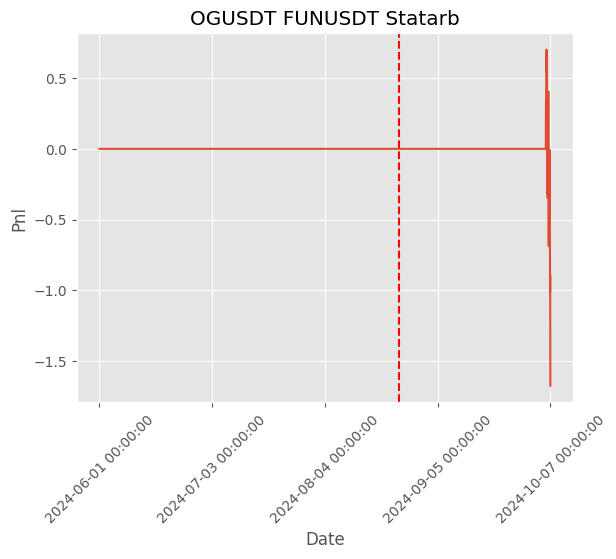

In [12]:
"""
Trade OGUSDT vs. FUNUSDT

OGUSDT = 882.14 * FUNUSDT - 0.09
"""

engine = Backtester(start_time, end_time, test_end_time, increment)

col1 = 'OGUSDT_close'
col2 = 'FUNUSDT_close'

while engine.get_date() < test_end_time:
    beta = 882.14
    intercept = 0.09

    data = engine.get_day_data()
    signal = data[col1] - (beta*data[col2] - intercept)

    """
    If signal is positive, then OGUSDT is too high
    Sell 1 OGUSDT and buy 882.14 FUNUSDT, in proportion to the signal
    """

    desired_position = {'OGUSDT': -signal, 'FUNUSDT': beta*signal}
    curr_position = engine.get_position()

    position_change = {}
    relevantTickers = list(curr_position.keys()) + list(desired_position.keys())

    for ticker in relevantTickers:
        desired = desired_position.get(ticker, 0)
        current = curr_position.get(ticker, 0)
        position_change[ticker] = desired - current
    engine.input_signals(position_change)

engine.graph_pnl('OGUSDT FUNUSDT Statarb')

In [13]:
# Graphs pnl, stock1 data & stock2 data, and the stationary equation
def graph_statarb(stock1, stock2, slope, intercept, engine, stopLoss = None):
    plt.style.use('ggplot')
    gridsize = (4, 3)
    fig = plt.figure(figsize=(12,8))

    # prepare x axis and data
    dates = engine.get_all_dates()
    xticks = dates[::len(dates)//4]
    xlabels = [date.strftime("%m-%d") for date in xticks]

    pnls = engine.get_all_pnls()
    data = engine.get_all_data()

    positions = engine.get_all_positions()
    stock1Position = [entry[stock1] for entry in positions]
    stock2Position = [entry[stock2] for entry in positions]
    stock1Data = data[f'{stock1}_close']
    stock2Data = data[f'{stock2}_close']
    btcData = data['BTCUSDT_close']
    predictor = stock1Data - (slope * stock2Data + intercept)

    # Pnl
    ax1 = plt.subplot2grid(gridsize, (0,0), rowspan=2, colspan=2)
    ax1.plot(dates, pnls)
    ax1.set_title(f'{stock1} = {slope}*{stock2} + {intercept} Pnl')
    ax1.set_xticks(xticks, xlabels)
    ax1.axvline(x=engine.end_train, color='red', linestyle='--')
    if stopLoss: ax1.axvline(x=stopLoss, color='blue', linestyle='--')

    # Close Prices
    ax2 = plt.subplot2grid(gridsize, (2, 0), rowspan=1, colspan=1)
    ax2.plot(dates, stock1Data, color='b')
    ax2.text(0.5, 0.85, f'{stock1} Close Price',
             transform=ax2.transAxes, horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.6))
    ax2.set_xticks(xticks, xlabels)

    ax3 = plt.subplot2grid(gridsize, (2, 1), rowspan=1, colspan=1)
    ax3.plot(dates, stock2Data, color='b')
    ax3.text(0.5, 0.85, f'{stock2} Close Price',
             transform=ax3.transAxes, horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.6))
    ax3.set_xticks(xticks, xlabels)

    # Positions
    ax4 = plt.subplot2grid(gridsize, (3, 0), rowspan=1, colspan=1)
    ax4.plot(dates, stock1Position, color='g')
    ax4.text(0.5, 0.85, f'{stock1} Position',
             transform=ax4.transAxes, horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.6))
    ax4.set_xticks(xticks, xlabels)

    ax5 = plt.subplot2grid(gridsize, (3, 1), rowspan=1, colspan=1)
    ax5.plot(dates, stock2Position, color='g')
    ax5.text(0.5, 0.85, f'{stock2} Position',
             transform=ax5.transAxes, horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.6))
    ax5.set_xticks(xticks, xlabels)

    # Predictor
    ax6 = plt.subplot2grid(gridsize, (1, 2), rowspan=1, colspan=1)
    ax6.plot(dates, predictor, color='g')
    ax6.text(0.5, 0.85, f'Predictor',
             transform=ax6.transAxes, horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.6))
    ax6.set_xticks(xticks, xlabels)
    ax6.axvline(x=engine.end_train, color='red', linestyle='--')
    if stopLoss: ax6.axvline(x=stopLoss, color='blue', linestyle='--')

    # Bitcoin
    ax7 = plt.subplot2grid(gridsize, (0, 2), rowspan=1, colspan=1)
    ax7.plot(dates, btcData, color='b')
    ax7.text(0.5, 0.85, f'BTCUSDT Close Price',
             transform=ax7.transAxes, horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.6))
    ax7.set_xticks(xticks, xlabels)

    # Sharpe and Volume
    backtest_end_index = dates.index(engine.end_train)
    pnlTrain = pnls[:backtest_end_index]
    pnlTest = pnls[backtest_end_index+1: dates.index(stopLoss)] if stopLoss else pnls[backtest_end_index+1:]
    pnlValue = pnlTest[-1] - pnlTest[0]

    sharpeTrain = (pnlTrain[-1] - pnlTrain[0])/np.std(pnlTrain)
    sharpeTest = (pnlTest[-1] - pnlTest[0])/np.std(pnlTest)

    stock1Volume = np.mean(data[f'{stock1}_close'] * data[f'{stock1}_volume'])
    stock2Volume = np.mean(data[f'{stock2}_close'] * data[f'{stock2}_volume'])
    
    ax8 = plt.subplot2grid(gridsize, (2, 2), rowspan=2, colspan=1)
    ax8.text(0.5, 0.85, f'Sharpe (train): {sharpeTrain:.2f}',
             transform=ax8.transAxes, horizontalalignment='center')
    ax8.text(0.5, 0.75, f'Sharpe (test): {sharpeTest:.2f}',
             transform=ax8.transAxes, horizontalalignment='center')
    
    ax8.text(0.5, 0.6, f'{stock1} Hourly Volume: ${stock1Volume:,.2f}',
             transform=ax8.transAxes, horizontalalignment='center')
    ax8.text(0.5, 0.5, f'{stock2} Hourly Volume: ${stock2Volume:,.2f}',
             transform=ax8.transAxes, horizontalalignment='center')
    
    ax8.text(0.5, 0.3, f'Fees Paid: ${engine.fees[-1]:.2g}',
             transform=ax8.transAxes, horizontalalignment='center')
    ax8.text(0.5, 0.2, f'Pnl Test: ${pnlValue:.2g}',
             transform=ax8.transAxes, horizontalalignment='center')

    
    ax8.axis('off')

def test_statarb(stock1, stock2, slope, intercept, signalStd=1):
    engine = Backtester(start_time, end_time, test_end_time, increment)

    col1 = f'{stock1}_close'
    col2 = f'{stock2}_close'

    predictorLow = 0
    predictorHigh = 0
    stopLoss = None

    while engine.get_date() < test_end_time:
        beta = slope
        intercept = intercept

        data = engine.get_day_data()
        signal = data[col1] - (beta*data[col2] + intercept)
        signal = signal / signalStd # signal normalized

        # Add stop loss
        if engine.get_date() < end_time:
            predictorLow = min(predictorLow, signal)
            predictorHigh = max(predictorHigh, signal)
        if not stopLoss and engine.get_date() > end_time:
            if signal < predictorLow or signal > predictorHigh:
                stopLoss = engine.get_date()

        """
        If signal is positive, then OGUSDT is too high
        Sell 1 OGUSDT and buy 882.14 FUNUSDT, in proportion to the signal
        """

        position_dollars = abs(data[col1]) + abs(data[col2]*beta) # per 1 signal, this is dollars
        position_volume = signal * (100/position_dollars) # 1 std signal --> $100 worth of stock

        desired_position = {stock1: -position_volume, stock2: beta*position_volume}
        curr_position = engine.get_position()

        position_change = {}
        relevantTickers = list(curr_position.keys()) + list(desired_position.keys())

        for ticker in relevantTickers:
            desired = desired_position.get(ticker, 0)
            current = curr_position.get(ticker, 0)
            position_change[ticker] = desired - current

        engine.input_signals(position_change)

    graph_statarb(stock1, stock2, slope, intercept, engine, stopLoss)

In [ ]:
test_statarb('BOBAUSDT', 'OPPERP', 0.11161, 0.055405, 0.0069314)
test_statarb('BOBAUSDT', 'SHIB1000PERP', 10.91, 0.058972, 0.0066636)
test_statarb('BOBAUSDT', 'ETCPERP', 0.01217, -0.025953, 0.0076501)
test_statarb('OGUSDT', 'FUNUSDT', 882.14, -0.094366, 0.090828)
test_statarb('XCNUSDT', 'BOBAUSDT', 0.0060625, 3.608e-05, 6.4615e-05)
test_statarb('XCNUSDT', 'ETCPERP', 7.6725e-05, -0.00018775, 4.7922e-05)
test_statarb('SCRTUSDT', 'ONDOPERP', 0.25492, 0.014382, 0.017022)
# test_statarb('BOBAUSDT', 'CEEKUSDT', 5.1202, 0.058133, 0.008222)
# test_statarb('OSMOUSDT', 'CEEKUSDT', 17.422, -0.13159, 0.018038)
test_statarb('BALUSDT', 'XCHUSDT', 0.12793, 0.0098473, 0.092955)
test_statarb('BOBAUSDT', 'OGUSDT', 0.06116, 0.050148, 0.0094699)
test_statarb('BOBAUSDT', 'FUNUSDT', 54.638, 0.041773, 0.0093603)
test_statarb('OGUSDT', 'SHIB1000PERP', 170.9, 0.27453, 0.13334)
test_statarb('BOBAUSDT', 'OSMOUSDT', 0.29192, 0.097831, 0.0076049)
test_statarb('BOBAUSDT', 'ARBPERP', 0.22253, 0.082817, 0.008002)
test_statarb('AEVOPERP', 'SHIB1000PERP', 48.891, -0.33363, 0.043244)
test_statarb('XCNUSDT', 'SCRTUSDT', 0.0039488, 0.00046395, 6.1929e-05)
# test_statarb('CEEKUSDT', 'SHIB1000PERP', 2.0766, 0.0011058, 0.0013107)
test_statarb('ONDOPERP', 'ARBPERP', 1.2489, 0.08554, 0.067898)
test_statarb('IDEXUSDT', 'LTOUSDT', 0.24789, 0.01044, 0.0020775)

# Forward Testing

In [53]:
start_time = datetime(2024, 8, 1, 0, 0)
end_time = datetime(2024, 10, 7, 0, 0)
test_end_time = datetime(2024, 10, 30, 0, 0)
increment = timedelta(hours=1)

In [ ]:
test_statarb('TIAPERP', 'MNTPERP', 14.811, -3.7559, 0.46739)
# test_statarb('TIAPERP', 'ONDOPERP', 7.0865, 0.19759, 0.43472)
# test_statarb('DGBUSDT', 'ETH-28MAR25', 1.3735e-06, 0.0030763, 0.00035212)
# test_statarb('TIAPERP', 'ETHFIPERP', 3.2837, 0.36726, 0.46345)
# test_statarb('DGBUSDT', 'ETCPERP', 0.00036568, -0.00015874, 0.00030344)
# test_statarb('DGBUSDT', 'ETH-27DEC24', 1.4405e-06, 0.0029837, 0.00035144)
# test_statarb('FORTHUSDT', 'FUNUSDT', 1014.2, -0.43762, 0.060189)
# test_statarb('ARBPERP', 'ETHFIPERP', 0.27085, 0.1614, 0.016934)
# test_statarb('DGBUSDT', 'GNOUSDT', 2.8131e-05, 0.0022015, 0.00029619)
# test_statarb('TIAPERP', 'ETCPERP', 0.53336, -4.9412, 0.4869)
# test_statarb('OXTUSDT', 'SCRTUSDT', 0.24485, 0.02125, 0.0033312)
# test_statarb('VTHOUSDT', 'ETHFIPERP', 0.00070545, 0.00096964, 6.5433e-05)
# test_statarb('DGBUSDT', 'COMBOUSDT', 0.010374, 0.0024461, 0.0002534)
# test_statarb('SUIPERP', 'ETHFIPERP', 0.9008, -0.22335, 0.35693)
# test_statarb('OXTUSDT', 'XCNUSDT', 48.514, 0.0074047, 0.0025626)
# test_statarb('OSMOUSDT', 'ETHFIPERP', 0.32422, -0.02445, 0.070224)
# test_statarb('AEVOPERP', 'MNTPERP', 0.89831, -0.17899, 0.022294)
# test_statarb('OSMOUSDT', 'MNTPERP', 1.0424, -0.17976, 0.078562)
# test_statarb('DGBUSDT', 'ETHFIPERP', 0.0018711, 0.0040316, 0.00034446)
# test_statarb('TIAPERP', 'ARBPERP', 12.551, -1.8262, 0.389)